In [4]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import torch
import joblib
from sklearn import preprocessing
%matplotlib inline
from sklearn import ensemble
from utils import loadData
from sklearn.neural_network import MLPRegressor
from utils import loadData, saveData, saveans, wavelet_denoising
from tqdm import tqdm
import graphviz
import lightgbm as lgb

In [78]:
def tkeo(arr):
    arr = arr.reshape(-1, 1000)
    tkeo = np.copy(arr)
    # Teager–Kaiser Energy operator
    tkeo[:, 1:-1] = arr[:, 1:-1]*arr[:, 1:-1] - arr[:, :-2]*arr[:, 2:]
    # correct the data in the extremities
    tkeo[:, 0], tkeo[:, -1] = tkeo[:, 1], tkeo[:, -2]
    return(tkeo)

In [2]:
testpath = "../data/final-problem.h5"
trainpath = "../data/final-3.h5"
geopath = "../data/geonew.h5"

In [3]:
trainPET, trainWF, trainPT = loadData(trainpath, 'PT')

Structure of data:
<HDF5 dataset "PETruth": shape (9307951,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6107301,), type "|V2008"> Waveform /Waveform


In [13]:
testWF = loadData(testpath, 'test')

Structure of data:
<HDF5 dataset "Waveform": shape (11973925,), type "|V2008"> Waveform /Waveform


In [5]:
e_tru, i_tru = np.unique(trainPET[:, 0], return_index=True)
i_tru = np.append(i_tru, len(trainPET))
# e_tru_m1, i_tru_m1 = np.unique(trainPET[trainPET[:, -1]==-1][:, 0], return_index=True)
# i_tru_m1 = np.append(i_tru_m1, len(trainPET[trainPET[:, -1]==-1]))
# e_tru_0, i_tru_0 = np.unique(trainPET[trainPET[:, -1]==0][:, 0], return_index=True)
# i_tru_0 = np.append(i_tru_0, len(trainPET[trainPET[:, -1]==0]))
# e_tru_1, i_tru_1 = np.unique(trainPET[trainPET[:, -1]==1][:, 0], return_index=True)
# i_tru_1 = np.append(i_tru_1, len(trainPET[trainPET[:, -1]==1]))
w_tru, j_tru = np.unique(trainWF['EventID'], return_index=True)
j_tru = np.append(j_tru, len(trainWF))
numPET = np.diff(i_tru)
# numPETm1 = np.diff(i_tru_m1)
# numPET0 = np.diff(i_tru_0)
# numPET1 = np.diff(i_tru_1)
numPEW = np.diff(j_tru)
invTrainWF = 1000-trainWF['Waveform']

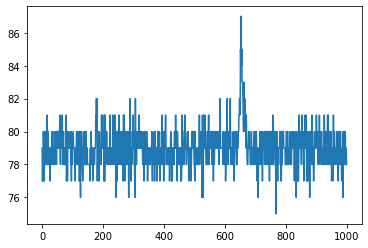

In [6]:
plt.plot(range(1000), invTrainWF[3085225])
plt.show()

In [7]:
thres = 300
intWF = np.array([])
numFiltered = np.array([])
for arr in tqdm(np.split(invTrainWF, j_tru[1:-1])):

    arr = wavelet_denoising(arr)

    head = np.mean(arr[:, :100], axis=1)
    tail = np.mean(arr[:, -100:], axis=1)
    base = np.minimum(head, tail)
    intpWF = np.sum(arr, axis=1)-tail*1000
    filtered = np.maximum(intpWF, thres)
    numFiltered = np.sum(filtered==thres)
    intWF = np.append(intWF, np.sum(filtered)-numFiltered*thres)

100%|██████████| 2000/2000 [02:58<00:00, 11.21it/s]


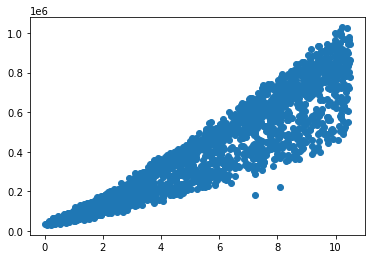

In [144]:
plt.scatter(trainPT[:, -2], intWF)
#plt.plot(trainPT[:, -2], numPEW*4)
plt.show()

In [82]:
np.argmax(np.abs(trainPT[:, -2]-8.09464696)<0.001)

1007

In [10]:
intMaxWF = np.array([])
for arr in tqdm(np.split(invTrainWF, j_tru[1:-1])):
    intMaxWF = np.append(intMaxWF, np.sum(np.max(arr, axis=1)))

100%|██████████| 2000/2000 [00:06<00:00, 292.21it/s]


In [81]:
intTKEOWF = np.array([])
for arr in tqdm(np.split(invTrainWF, j_tru[1:-1])):
    intTKEOWF = np.append(intTKEOWF, np.sum(tkeo(arr)))

100%|██████████| 2000/2000 [00:19<00:00, 102.38it/s]


In [34]:
intWFt = np.array([])
for arr in tqdm(np.split(invTrainWF, j_tru[1:-1])):
    intWFt = np.append(intWFt, np.sum(arr*(np.arange(1000)+1))-np.sum(np.mean(arr[:, -20:], axis=1)*1000*999/2))

 15%|█▍        | 299/2000 [00:02<00:15, 107.65it/s]


KeyboardInterrupt: 

In [14]:
w_test, j_test = np.unique(testWF['EventID'], return_index=True)
j_test = np.append(j_test, len(testWF))
numPEWtest = np.diff(j_test)
invTestWF = 1000-testWF['Waveform']

In [121]:
intWFtest = np.array([])
numFilteredTest = np.array([])
for arr in tqdm(np.split(invTestWF, j_test[1:-1])):
    head = np.mean(arr[:, :100], axis=1)
    tail = np.mean(arr[:, -100:], axis=1)
    base = np.minimum(head, tail)
    intpWF = np.sum(arr, axis=1)-tail*1000
    filtered = np.maximum(intpWF, thres)
    numFiltered = np.sum(filtered==thres)
    intWFtest = np.append(intWFtest, np.sum(filtered)-numFiltered*thres)
# numPEWtest = numPEWtest - numFilteredTest

100%|██████████| 4000/4000 [00:21<00:00, 189.20it/s]


In [23]:
intMaxWFtest = np.array([])
for arr in tqdm(np.split(invTestWF, j_test[1:-1])):
    intMaxWFtest = np.append(intMaxWFtest, np.sum(np.max(arr, axis=1)))

100%|██████████| 4000/4000 [00:13<00:00, 303.02it/s]


In [92]:
intTKEOWFtest = np.array([])
for arr in tqdm(np.split(invTestWF, j_test[1:-1])):
    intTKEOWFtest = np.append(intTKEOWFtest, np.sum(tkeo(arr)))

100%|██████████| 4000/4000 [00:37<00:00, 106.47it/s]


In [11]:
intWFtTest = np.array([])
for arr in tqdm(np.split(invTestWF, j_test[1:-1])):
    intWFtTest = np.append(intWFtTest, np.sum(arr*(np.arange(1000)+1))-np.sum(np.mean(arr[:, -200:], axis=1)*1000*999/2))

100%|██████████| 4000/4000 [00:35<00:00, 111.12it/s]


In [94]:
Xtest = np.hstack((numPEWtest.reshape(-1, 1), intWFtest.reshape(-1, 1), intMaxWFtest.reshape(-1, 1), intTKEOWFtest.reshape(-1,1)))

In [13]:
saveData(Xtest, np.array([0]), './data/testv3.h5')

In [60]:
Xtest, _ = loadData('./data/testv3.h5', 'pro')

In [8]:
X1 = np.hstack((numPEW.reshape(-1, 1), intWF.reshape(-1, 1)))#intMaxWF.reshape(-1,1), intTKEOWF.reshape(-1,1)))
Y1 = trainPT[:, -1]

In [43]:
saveData(X1, trainPT, './data/train4.h5')

In [82]:
X1, Y1 = loadData('./data/train3.h5', 'pro')

In [9]:
train_data1 = lgb.Dataset(X1[:-100], label=Y1[:-100])
validation_data1 = lgb.Dataset(np.array(X1[-100:]), np.array(Y1[-100:]), reference=train_data1)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 2**11,
    'learning_rate': 0.01,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 20,
    'max_depth': 11,
}
gbm1 = lgb.train(params,
                train_data1,
                num_boost_round=3000,
                valid_sets=validation_data1,
                early_stopping_rounds=300)

31
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[684]	valid_0's rmse: 1040.64
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[685]	valid_0's rmse: 1040.57
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[686]	valid_0's rmse: 1040.65
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[687]	valid_0's rmse: 1040.51
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[688]	valid_0's rmse: 1040.57
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[689]	valid_0's rmse: 1040.59
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[690]	valid_0's rmse: 1040.63
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[691]	valid_0's rmse: 1040.63
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[692]	valid_0's rmse: 1040.54
[LightGBM] [Warning] No further splits with positive

In [11]:
X2 = np.hstack((X1, gbm1.predict(X1).reshape(-1,1)))
Y2 = numPET

In [12]:
train_data2 = lgb.Dataset(X2[:-100], label=Y2[:-100])
validation_data2 = lgb.Dataset(np.array(X2[-100:]), np.array(Y2[-100:]), reference=train_data2)
gbm2 = lgb.train(params,
                train_data2,
                num_boost_round=3000,
                valid_sets=validation_data2,
                early_stopping_rounds=300)

f
[991]	valid_0's rmse: 70.0991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[992]	valid_0's rmse: 70.1165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[993]	valid_0's rmse: 70.1133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[994]	valid_0's rmse: 70.1087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[995]	valid_0's rmse: 70.1287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[996]	valid_0's rmse: 70.1328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[997]	valid_0's rmse: 70.1269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[998]	valid_0's rmse: 70.1453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[999]	valid_0's rmse: 70.1638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1000]	valid_0's rmse: 70.1579
[LightGBM] [Warning] N

In [13]:
X = np.hstack((X2, gbm2.predict(X2).reshape(-1,1)))
# X = X2
Y = trainPT[:, -2]/1-np.exp(-trainPT[:, -2])


In [14]:
train_data = lgb.Dataset(np.array(X[:-100]), label=np.array(Y[:-100]))
validation_data = lgb.Dataset(np.array(X[-100:]), np.array(Y[-100:]), reference=train_data)
gbm = lgb.train(params,
                train_data,
                num_boost_round=3000,
                valid_sets=validation_data,
                early_stopping_rounds=300)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[831]	valid_0's rmse: 0.543153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[832]	valid_0's rmse: 0.543235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[833]	valid_0's rmse: 0.543142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[834]	valid_0's rmse: 0.543225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[835]	valid_0's rmse: 0.543115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[836]	valid_0's rmse: 0.543191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[837]	valid_0's rmse: 0.5431
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[838]	valid_0's rmse: 0.543182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[839]	valid_0's rmse: 0.543226
[LightGBM] [Warning] No further splits with pos

In [196]:
Xtest = np.hstack((numPEWtest.reshape(-1, 1), intWFtest.reshape(-1, 1)))
Xt1 = np.hstack((Xtest, gbm1.predict(Xtest).reshape(-1,1)))
Xt = np.hstack((Xt1, gbm2.predict(Xt1).reshape(-1,1)))
# Xt = Xt1

In [195]:
from pynverse import inversefunc
trans = lambda x: x/1-np.exp(-x)
invtrans = inversefunc(trans)

In [197]:
ans_gbm = invtrans(gbm.predict(Xt))
expname = 'dGBM'
saveans(ans_gbm, './ans/'+expname+'.h5')

In [198]:
trainPET

array([[ 0.00000000e+00,  4.00000000e+00,  6.00022656e+02,
         1.00000000e+00],
       [ 0.00000000e+00,  8.00000000e+00,  6.04903013e+02,
         1.00000000e+00],
       [ 0.00000000e+00,  1.10000000e+01,  5.76875682e+02,
         1.00000000e+00],
       ...,
       [ 1.99900000e+03,  1.75810000e+04,  6.01051849e+02,
         1.00000000e+00],
       [ 1.99900000e+03,  1.76070000e+04,  5.86866675e+02,
         1.00000000e+00],
       [ 1.99900000e+03,  1.76090000e+04,  6.40730998e+01,
        -1.00000000e+00]])

In [135]:
gbm1.feature_importance()

array([22543, 16897], dtype=int32)

In [10]:
trainPT[:, -1]

array([18971., 23288., 41752., ..., 10660., 12040., 11545.])

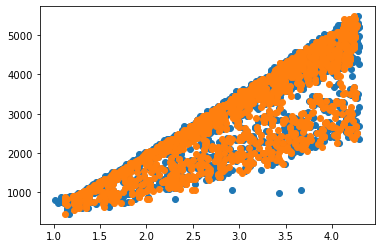

In [190]:
# plt.scatter(trainPT[:, -1], numPEW)
# plt.scatter(trainPT[:, -1], numPET)
# plt.scatter(trainPT[:, -1], numPET1)
# plt.scatter(trainPT[:, -1], intWF/trainPT[:, -1])
# plt.scatter(trainPT[:, -2], trainPT[:,-2]/intWF)
# plt.scatter(gbm.predict(X), gbm.predict(X)/intWF)
# plt.scatter(np.log(trainPT[:, -2]+1), trainPT[:,-2]/numPEW)
# plt.scatter(np.log(gbm.predict(X)+1), gbm.predict(X)/numPEW)
plt.scatter(trainPT[:, -2]/np.log(trainPT[:, -2]+1), numPEW)
plt.scatter(gbm.predict(X), numPEW)
#plt.scatter(trainPT[:10, -1], trainPT[:10, -2]*1000)
# plt.scatter(gbm1.predict(X1), intWF/100)
#plt.scatter(trainPT[:10, -1], gbm.predict(X)[:10]*1000)
#plt.scatter(numPEW, numPET)
plt.show()

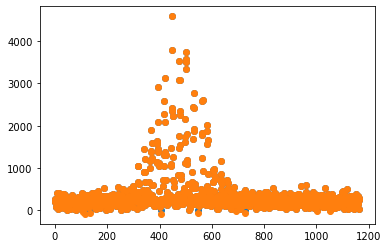

In [142]:
arr = invTrainWF[3085221:3086386]
head = np.mean(arr[:, :100], axis=1)
tail = np.mean(arr[:, -100:], axis=1)
base = np.minimum(head, tail)
intWF0 = np.sum(arr, axis=1)-base*1000
plt.scatter(range(3086386-3085221),  (np.abs(intWF0)+intWF0)/2)
plt.scatter(range(3086386-3085221),  intWF0)
plt.show()

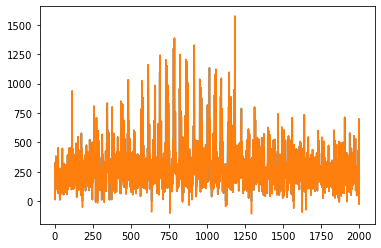

In [107]:
arr = invTrainWF[:2000]
head = np.mean(arr[:, :100], axis=1)
tail = np.mean(arr[:, -100:], axis=1)
base = np.minimum(head, tail)
intWF0 = np.sum(arr, axis=1)-base*1000
plt.plot(range(2000),  (np.abs(intWF0)+intWF0)/2)
plt.plot(range(2000),  intWF0)
plt.show()

In [135]:
np.argmin(intWF0)

2414

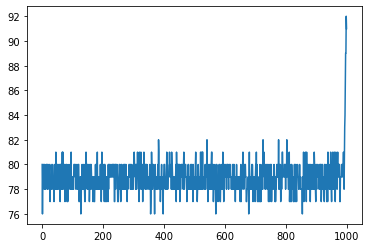

In [136]:
plt.plot(invTrainWF[2414])

In [85]:
j_tru[1007], j_tru[1008]

(3085221, 3086386)

In [17]:
X1

array([18971., 23288., 41752., ..., 10660., 12040., 11545.])